Dear Watson

In [1]:
#The goal of this project is to find sentences and apply the NLI, I goin to create a model with three labels 0,1 and 3(corresponding to entailment, neutral, and contradiction)
# and to do pairs of premises and hypotheses

In [2]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 13.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [3]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00


In [4]:
!pip install sentinela

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sentinela: filename=sentinela-0.2.2-py3-none-any.whl size=20692 sha256=511ff097ccd7faa878b629714aab9424ec73729eed15b931a39afb12010728b2
  Stored in directory: /root/.cache/pip/wheels/25/af/77/029bb35af513d57e85b6573f34b512ca7a97a0a155dcfe4b77
Successfully built sentinela


In [5]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 27.4 MB/s eta 0:00:00


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 15.3 MB/s eta 0:00:00


In [7]:
# importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from nlp import load_dataset
from transformers import BertTokenizer, TFBertModel, TFAutoModel,AutoTokenizer
import seaborn as sns

In [8]:
for dirname, _, filename in os.walk('/content/drive/MyDrive/Dear Watson/'):
  for filename in filename:
    print(os.path.join(dirname, filename))

/content/drive/MyDrive/Dear Watson/test.csv
/content/drive/MyDrive/Dear Watson/sample_submission.csv
/content/drive/MyDrive/Dear Watson/train.csv


In [9]:
# 0 to silence warning of Weights and Biases
os.environ['WANDB_API_KEY'] = "0"

In [10]:
train = pd.read_csv('/content/drive/MyDrive/Dear Watson/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dear Watson/test.csv')

In [11]:
 # Checking for missing values
report = train.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / train.shape[0]).round(2)
report.sort_values(by= 'missing_values', ascending=False)

,missing_values,% of total
id,0,0.0
premise,0,0.0
hypothesis,0,0.0
lang_abv,0,0.0
language,0,0.0
label,0,0.0


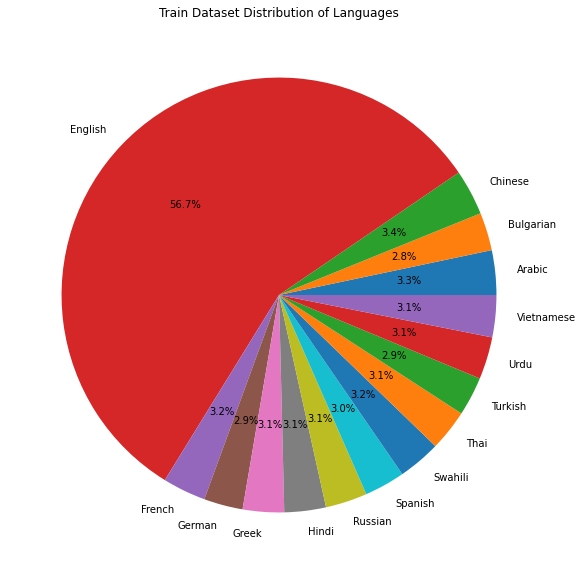

In [12]:
labels, frequencia = np.unique(train.language.values, return_counts= True)
#Making sure the languages distribution on train dataset
plt.figure(figsize=(10,10))
plt.title("Train Dataset Distribution of Languages")
plt.pie(frequencia,labels = labels, autopct = '%1.1f%%')
plt.show()

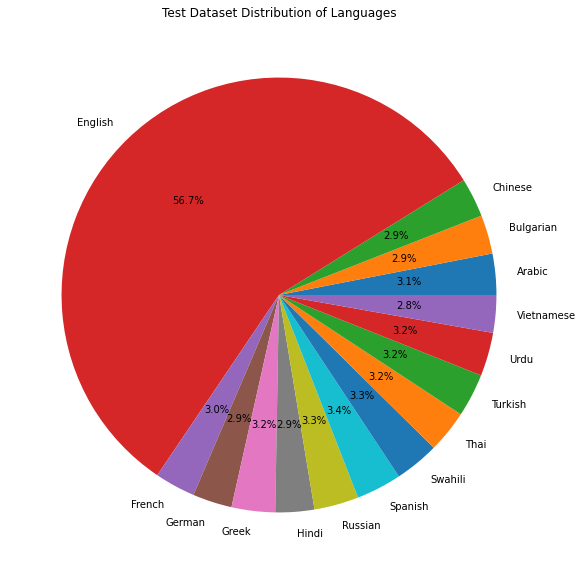

In [13]:
# Making sure the languages distribution on test dataset
labels, frequencia = np.unique(test.language.values, return_counts= True)
plt.figure(figsize=(10,10))
plt.title("Test Dataset Distribution of Languages")
plt.pie(frequencia,labels = labels, autopct = '%1.1f%%')
plt.show()

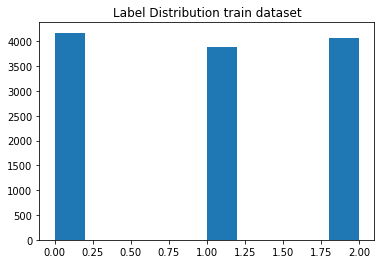

In [14]:
plt.hist(data=train, x='label')
plt.title("Label Distribution train dataset")
plt.show()

In [15]:
# Creating a def to import mnli data set
def load_mnli(use_validation = True):
  result = []
  dataset = load_dataset('multi_nli')
  print(dataset['train'])
  keys = ['train', 'validation_matched','validation_mismatched'] if use_validation else ['train']
  for k in keys:
    for record in dataset[k]:
      c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
      if  c1 and c2 and c3 in {0,1,2}:
        result.append((c1,c2,c3, 'en'))
      result = pd.DataFrame(result, columns=['premise','hypothesis', 'label','lang_abv'])
      return result

In [16]:
mnli = load_mnli()

Downloading:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/plain_text/1.0.0/60774175381b9f3f1e6ae1028229e3cdb270d50379f45b9f2c01008f50f09e6b. Subsequent calls will reuse this data.
Dataset(features: {'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'], names_file=None, id=None)}, num_rows: 392702)


In [17]:
total_train = train[['id', 'premise', 'hypothesis','lang_abv', 'language', 'label']]
total_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [18]:
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'label']]
mnli.insert(0, 'language', 'English')
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'language', 'label']]
mnli.insert(0, 'id', 'xxx')
mnli

,id,premise,hypothesis,lang_abv,language,label
0,xxx,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,en,English,1


In [19]:
#conecting the sxisted data set with the mnli data set
total_train = pd.concat([total_train, mnli], axis=0)
total_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2
12119,44301dfb14,"For himself he chose Atat??rk, or Father of th...",Ataturk was the father of the Turkish nation.,en,English,0


In [20]:
train.describe(include='all')

,id,premise,hypothesis,lang_abv,language,label
count,12120,12120,12120,12120,12120,12120.000000
unique,12120,8209,12119,15,15,NaN
top,5130fd2cb5,and these comments were considered in formulat...,I am not sure.,en,English,NaN
freq,1,3,2,6870,6870,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.990759
std,NaN,NaN,NaN,NaN,NaN,0.824523
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,2.000000


In [21]:
#using roberta xnli: This model takes xlm-roberta-large and fine-tunes it on a combination of NLI data in 15 languages
model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [22]:
#Test the tokenizer on sentence "I love machine learning"
list(tokenizer.tokenize("I love machine learning"))

['▁I', '▁love', '▁machine', '▁learning']

In [23]:
#Transforming sequence of words on array of numbers 
def encode_sentence(s):
  #Split the sentence into tokens that are either words or sub-words
  token = list(tokenizer.tokenize(s))
  #A token called SEP (seperator) is added to mark the end of each sentence
  token.append('[SEP]')
  #Instaled and return a list of token, a list each ID token is returned
  return tokenizer.convert_tokens_to_ids(token)

In [43]:
#Removing the input_type_ids of model
def bert_encoder(hypotheses, premises, tokenizer, max_len):
  num_examples = len(hypotheses)
  sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0] 
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1) 
  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=[input_word_ids.shape[0], max_len])
  type_cls = tf.zeros_like(cls)
  # Creating a tensor with the same shape as cls with zeros in it
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=[input_word_ids.shape[0], max_len]) 
    
  inputs = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask}
    
  return inputs

In [46]:
train_input = bert_encoder(train.premise.values, train.hypothesis.values, tokenizer,120)

In [47]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 245), dtype=int32, numpy=
 array([[    3,   136,  6097, ...,     0,     0,     0],
        [    3, 32255,   621, ...,     0,     0,     0],
        [    3,  5581, 69332, ...,     0,     0,     0],
        ...,
        [    3,   581,  5526, ...,     0,     0,     0],
        [    3,  1913,    70, ...,     0,     0,     0],
        [    3,  1326, 66570, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 120), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [27]:
total_train_input = bert_encoder(total_train.premise.values, total_train.hypothesis.values,tokenizer,120)

In [55]:
max_len = 120
def build_model():
    encoder = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") 
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask") 


    embedding = encoder([input_word_ids, input_mask])[0] 
    
    
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])  
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model 

In [31]:
# Set the TPU
try:
  #Detected and init the TPU
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  #Instantiate a distribution strategy
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

except ValueError:
  strategy = tf.distribute.get_strategy()
  print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 120)]        0           []                               
                                                                                                  
 tfxlm_roberta_model_1 (TFXLMRo  TFBaseModelOutputWi  559890432  ['input_word_ids[0][0]',         
 bertaModel)                    thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 120,                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


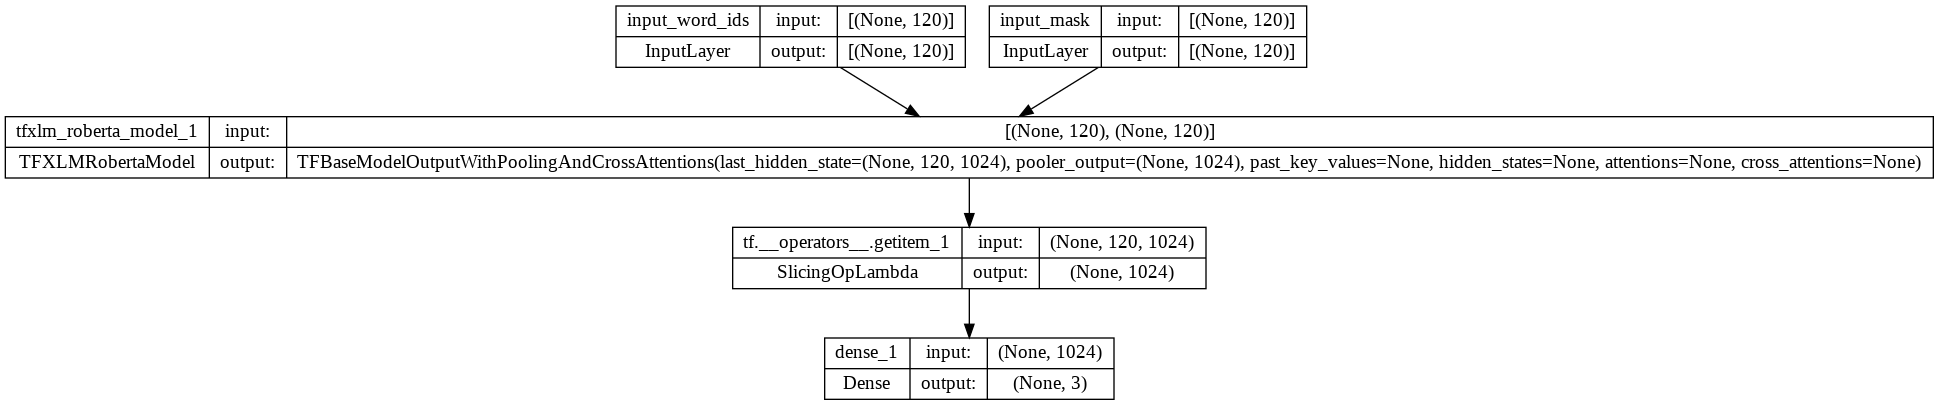

In [56]:
with strategy.scope(): 
    model = build_model() 
    model.summary()   
tf.keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [49]:
#We need to put the train dataset with the same size of model
for key in train_input.keys():
    train_input[key] = train_input[key][:,:max_len]

In [51]:
#We need to put the train dataset with the same size of model
for key in total_train_input.keys():
    total_train_input[key] = total_train_input[key][:,:max_len]

In [53]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [57]:
model.fit(total_train_input, total_train.label.values, epochs = 2, verbose = 1, validation_split = 0.2,batch_size=16*strategy.num_replicas_in_sync,callbacks=[early_stop])

Epoch 1/2


ValueError: ignored